In [1]:
import pandas as pd
import numpy as n
import ROOT as R
#R.enableJSVis()
R.ROOT.EnableImplicitMT()

c1=R.TCanvas('c1','c1',900,700)

t=R.TLatex()
t.SetTextSize(0.04)

graphs={}



Welcome to JupyROOT 6.18/04


In [2]:
#few functions definition

logit=R.TF1("logit","[0]/(1+TMath::Exp(-[1]*(x-[2])))",0,100)
logit.SetParameter(0,100)
logit.SetParLimits(0,0,10000)
logit.SetParameter(1,3)
logit.SetParLimits(1,0.,50.)
logit.SetParameter(2,5)
logit.SetParLimits(2,0.,200.)

f=R.TF1("ff","TMath::Exp((x+[0])/[1])",0,100)
f.SetParameter(0,13)
f.SetParLimits(0,-100,100)
f.SetParameter(1,4.5)
f.SetParLimits(1,1.,6.)


def rebinGraph(g,r,assignError):
    n=g.GetN()
    g1=R.TGraphErrors()
    g1.SetName(g.GetName()+'_rebin%d'%r)
    ibin=0
    average_Y=0
    average_X=0
    sumw2=0
    nbin=0
    for i in range(n):
        ibin+=1
        x,y=R.Double(0),R.Double(0)
        g.GetPoint(i,x,y)
        average_X+=x
        w2=1/(g.GetErrorY(i)*g.GetErrorY(i))
        average_Y+=y*w2
        sumw2+=w2
        if (ibin>=r or i==n-1):
            average_Y=average_Y/sumw2
            average_X=average_X/ibin
            err_Y=R.TMath.Sqrt(1/sumw2)
            err_X=r/2.
            g1.SetPoint(nbin,average_X,average_Y)
            if (assignError):
                g1.SetPointError(nbin,err_X,err_Y)
            else:
                g1.SetPointError(nbin,0,0)
            nbin+=1
            ibin=0
            average_Y=0
            average_X=0
            sumw2=0
    return g1

def integralGraph(g,firstPoint,lastPoint=-1):
    if (lastPoint==-1):
        lastPoint=g.GetN()
    integral=0
    error=0
    for i in range(firstPoint,lastPoint):
        x,y=R.Double(0),R.Double(0)
        g.GetPoint(i,x,y)
        integral+=y
        error+=g.GetErrorY(i)*g.GetErrorY(i)
    return [integral,R.TMath.Sqrt(error)]

smooth=R.TGraphSmooth()
smooth1=R.TGraphSmooth()

In [3]:
townRegion={
    'Brescia':'Lombardia',
    'Milano':'Lombardia',
    'Torino':'Piemonte',
    'Genova':'Liguria',
    'Roma':'Lazio'
}

townPopulation={
    'Brescia':196670,
    'Milano':1.352E6,
    'Torino':886837,
    'Genova':583601,
    'Roma':2.873E6
}

In [4]:
urlIstat = '~/Downloads/comuni_settimana.csv'
dfIstat = pd.read_csv(urlIstat)

In [5]:
#Official data from http://www.epiprev.it/sites/default/files/SISMG_COVID19_28032020.pdf
urlByTown = 'mortalita_settimanale_per_citta.csv'
dfByTown = pd.read_csv(urlByTown)

In [6]:
#Official data from Protezione Civile
urlByProvince = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'
urlNational = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
urlByRegion = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'


dfByProvince = pd.read_csv(urlByProvince,na_filter = False)
dfNational = pd.read_csv(urlNational)
dfByRegion = pd.read_csv(urlByRegion)

lastDate=dfNational['data'][len(dfNational)-1]

#dfByProvince.head(5)
#dfNational.head(5)

print("Last data %s"%lastDate)

Last data 2020-04-04T17:00:00


In [7]:
urlPopulation='comuni.csv'
dfByPopulation=pd.read_csv(urlPopulation)

#print(dfByPopulation.columns)
dfByPopulation['Totale']=dfByPopulation[['Totale Maschi','Totale Femmine']].sum(axis=1)
dfByPopulation=dfByPopulation[dfByPopulation['Età']==999]
#dfByPopulation=dfByPopulation.set_index('Denominazione')
dfByPopulation=dfByPopulation.drop(columns=['Età'])
dfByPopulation.head()

,Codice comune,Denominazione,Maschi celibi,Maschi coniugati,Maschi divorziati,Maschi vedovi,Maschi uniti civilmente,Maschi già in unione civile (per scioglimento),Maschi già in unione civile (per decesso del partner),Totale Maschi,Femmine nubili,Femmine coniugate,Femmine divorziate,Femmine vedove,Femmine unite civilmente,Femmine già in unione civile (per scioglimento),Femmine già in unione civile (per decesso del partner),Totale Femmine,Totale
101,1001,Agliè,540,602,46,49,NaN,NaN,NaN,1237,496,619,72,211,NaN,NaN,NaN,1398,2635
203,1002,Airasca,801,947,73,52,NaN,NaN,NaN,1873,637,950,58,163,NaN,NaN,NaN,1808,3681
305,1003,Ala di Stura,109,107,11,11,NaN,NaN,NaN,238,87,92,6,30,NaN,NaN,NaN,215,453
407,1004,Albiano d'Ivrea,349,395,36,28,NaN,NaN,NaN,808,282,399,39,118,NaN,NaN,NaN,838,1646
509,1006,Almese,1370,1552,111,88,NaN,NaN,NaN,3121,1164,1568,171,354,NaN,NaN,NaN,3257,6378


In [8]:
urlPopulationByRegion='regioni.csv'
dfPopulationByRegion=pd.read_csv(urlPopulationByRegion)

#print(dfPopulationByRegion.columns)
dfPopulationByRegion['Totale']=dfPopulationByRegion[['Totale Maschi','Totale Femmine']].sum(axis=1)
dfPopulationByRegion=dfPopulationByRegion[dfPopulationByRegion['Età']=='Totale']
#dfPopulationByRegion=dfPopulationByRegion.set_index('Denominazione')
dfPopulationByRegion=dfPopulationByRegion.drop(columns=['Età'])
dfPopulationByRegion.head()

,Regione,Maschi celibi,Maschi coniugati,Maschi divorziati,Maschi vedovi,Maschi uniti civilmente,Maschi già in unione civile (per scioglimento),Maschi già in unione civile (per decesso del partner),Totale Maschi,Femmine nubili,Femmine coniugate,Femmine divorziate,Femmine vedove,Femmine unite civilmente,Femmine già in unione civile (per scioglimento),Femmine già in unione civile (per decesso del partner),Totale Femmine,Totale
101,Piemonte,962714,1013052,75324,62849,1118,12,10,2115079,804470,1031805,107026,297391,620,14,1,2241327,4356406
203,Valle d'Aosta/Vallée d'Aoste,30180,26958,2623,1634,26,2,0,61423,25071,27486,3542,8126,16,2,0,64243,125666
305,Lombardia,2341426,2319286,140650,119919,3114,17,39,4924451,1984291,2358372,198515,593645,1253,18,29,5136123,10060574
407,Trentino-Alto Adige/Südtirol,271021,230664,15582,10730,209,0,4,528210,232930,234346,20811,55871,102,0,6,544066,1072276
509,Veneto,1126180,1150584,65721,56427,858,6,7,2399783,952850,1170382,89009,293396,425,4,5,2506071,4905854


In [9]:
regions = n.unique(dfIstat['NOME_REGIONE'])
#weeks=n.unique(dfIstat['SETTIMANA'])
weeks={'01/01-11/01':0 , '01/03-07/03':8, '02/02-08/02':4, '08/03-14/03':9, '09/02-15/02':5,
 '12/01-18/01':1, '15/03-21/03':10, '16/02-22/02':6, '19/01-25/01':2, '23/02-29/02':7,
 '26/01-01/02':3}
ages=n.unique(dfIstat['CLASSE_DI_ETA'])
print(ages)
for w,index in weeks.items():
#    print(index,w)
    dfIstat=dfIstat.replace(w,index)

for a in ages:
    age=a
    index=int(n.where(ages == a)[0])
#    print(index,age)
    dfIstat=dfIstat.replace(age,index)

['0-14 anni' '15-64 anni' '65-74 anni' '75 anni e più']


In [10]:
dfIstat.head()

,REG,PROV,COD_PROVCOM,NOME_REGIONE,NOME_PROVINCIA,NOME_COMUNE,SETTIMANA,CLASSE_DI_ETA,MASCHI_2015,MASCHI_2016,...,FEMMINE_2017,FEMMINE_2018,FEMMINE_2019,FEMMINE_2020,TOTALE_2015,TOTALE_2016,TOTALE_2017,TOTALE_2018,TOTALE_2019,TOTALE_2020
0,1,1,1001,Piemonte,Torino,Agliè,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1001,Piemonte,Torino,Agliè,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1001,Piemonte,Torino,Agliè,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1001,Piemonte,Torino,Agliè,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1001,Piemonte,Torino,Agliè,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
townSisgmToAdd=['Milano','Torino','Genova','Roma']
#townSisgmToAdd=[]


In [12]:
#organize Sisgm Data
df={}

provinces = n.unique(dfByTown['Town'])
for p in townSisgmToAdd:
    df[p]=dfByTown[dfByTown['Town']==p]
    df[p]=df[p].drop(columns=['Town'])
    df[p]=df[p].transpose()
    df[p].columns=['number_of_deaths']
    #df[p]=df[p].set_index('week')

In [13]:
dfDeaths={}
graphs={}
firstWeek=4
for p in regions:
    print('=======',p)
    dfDeaths[p]=dfIstat[dfIstat['NOME_REGIONE']==p]
    graphs['deceduti_%s'%p]=R.TGraphErrors()
    graphs['deceduti_%s'%p].SetName('deceduti_%s'%p)
    for w in range(firstWeek,len(weeks)):
            d=int(dfDeaths[p].loc[dfDeaths[p]['SETTIMANA']==w]['TOTALE_2020'].sum())
            graphs['deceduti_%s'%p].SetPoint(w-firstWeek,w+1,d)
            graphs['deceduti_%s'%p].SetPointError(w-firstWeek,0.5,R.TMath.Sqrt(d))
            print(p,w+1,d)


======= Abruzzo
Abruzzo 5 33
Abruzzo 6 30
Abruzzo 7 31
Abruzzo 8 34
Abruzzo 9 45
Abruzzo 10 38
Abruzzo 11 42
======= Basilicata
Basilicata 5 10
Basilicata 6 9
Basilicata 7 4
Basilicata 8 14
Basilicata 9 8
Basilicata 10 16
Basilicata 11 10
======= Calabria
Calabria 5 8
Calabria 6 11
Calabria 7 7
Calabria 8 13
Calabria 9 10
Calabria 10 16
Calabria 11 14
======= Campania
Campania 5 33
Campania 6 31
Campania 7 34
Campania 8 36
Campania 9 51
Campania 10 41
Campania 11 37
======= Emilia-Romagna
Emilia-Romagna 5 390
Emilia-Romagna 6 424
Emilia-Romagna 7 403
Emilia-Romagna 8 451
Emilia-Romagna 9 553
Emilia-Romagna 10 846
Emilia-Romagna 11 999
======= Friuli-Venezia Giulia
Friuli-Venezia Giulia 5 20
Friuli-Venezia Giulia 6 14
Friuli-Venezia Giulia 7 20
Friuli-Venezia Giulia 8 15
Friuli-Venezia Giulia 9 22
Friuli-Venezia Giulia 10 24
Friuli-Venezia Giulia 11 40
======= Lazio
Lazio 5 22
Lazio 6 26
Lazio 7 18
Lazio 8 15
Lazio 9 23
Lazio 10 35
Lazio 11 43
======= Liguria
Liguria 5 78
Liguria 6 93
L

In [14]:
#Add SigSM towns (missing from ISTAT)
sisgmFirstWeek=4
for p in townSisgmToAdd:
    print('======= %s'%p)
    for i,ni in enumerate(df[p]['number_of_deaths']):
        r=townRegion[p]
        x,y=R.Double(0),R.Double(0)
        graphs['deceduti_%s'%r].GetPoint(sisgmFirstWeek-firstWeek+i,x,y)
        y+=df[p]['number_of_deaths'][i]
        graphs['deceduti_%s'%r].SetPoint(i,i+sisgmFirstWeek+1,y)
        graphs['deceduti_%s'%r].SetPointError(i,0.5,R.TMath.Sqrt(y))
        print(p,r,i+sisgmFirstWeek+1,df[p]['number_of_deaths'][i],y)

======= Milano
Milano Lombardia 5 239 1430.0
Milano Lombardia 6 231 1383.0
Milano Lombardia 7 231 1394.0
Milano Lombardia 8 243 1489.0
Milano Lombardia 9 245 1962.0
Milano Lombardia 10 337 3409.0
Milano Lombardia 11 437 4235.0
======= Torino
Torino Piemonte 5 176 396.0
Torino Piemonte 6 183 394.0
Torino Piemonte 7 171 386.0
Torino Piemonte 8 173 388.0
Torino Piemonte 9 190 466.0
Torino Piemonte 10 208 536.0
Torino Piemonte 11 230 660.0
======= Genova
Genova Liguria 5 144 222.0
Genova Liguria 6 169 262.0
Genova Liguria 7 163 236.0
Genova Liguria 8 128 213.0
Genova Liguria 9 152 248.0
Genova Liguria 10 211 319.0
Genova Liguria 11 288 434.0
======= Roma
Roma Lazio 5 484 506.0
Roma Lazio 6 506 532.0
Roma Lazio 7 452 470.0
Roma Lazio 8 480 495.0
Roma Lazio 9 482 505.0
Roma Lazio 10 487 522.0
Roma Lazio 11 527 570.0


In [15]:
referenceWeek=5
for p in regions:
    graphs['deceduti_%s'%p].SetLineColor(R.kBlack)
    graphs['deceduti_%s'%p].SetMarkerColor(R.kBlack)
    graphs['deceduti_%s'%p].SetMarkerStyle(25)
    graphs['deceduti_%s'%p].SetMarkerSize(1.4)
    #Temporary: using as baseline fit of end of January/February data
    fB=R.TF1('fB','[0]*(1-0.0023*7*(x-%d))'%referenceWeek,0,100)
    graphs['deceduti_%s'%p].Fit('fB','RQB+','',referenceWeek-0.5,7.5)

    graphs['eccesso_deceduti_%s'%p]=R.TGraphErrors()
    graphs['eccesso_deceduti_%s'%p].SetName('eccesso_deceduti_%s'%p)
    for w in range(0,graphs['deceduti_%s'%p].GetN()):
        x,y=R.Double(0),R.Double(0)
        yerr=graphs['deceduti_%s'%p].GetErrorY(w)
        graphs['deceduti_%s'%p].GetPoint(w,x,y)
        graphs['eccesso_deceduti_%s'%p].SetPoint(w,x,y-graphs['deceduti_%s'%p].GetFunction('fB').Eval(x))
        graphs['eccesso_deceduti_%s'%p].SetPointError(w,0.5,yerr)
    graphs['eccesso_deceduti_%s'%p].SetLineColor(R.kBlack)
    graphs['eccesso_deceduti_%s'%p].SetMarkerColor(R.kBlack)
    graphs['eccesso_deceduti_%s'%p].SetMarkerStyle(25)
    graphs['eccesso_deceduti_%s'%p].SetMarkerSize(1.4)

In [16]:
comuni = n.unique(dfIstat['NOME_COMUNE'])
comuniPopolazione = n.unique(dfByPopulation['Denominazione'])
pop=0

populationIstatByRegion={}
populationTotalByRegion={}

for r in regions:
    populationIstatByRegion[r]=0
    populationTotalByRegion[r]=0
    
for c in comuni:
    if c in comuniPopolazione:
        p=int(dfByPopulation[dfByPopulation['Denominazione']==c]['Totale'])
        r=str(n.unique(dfIstat[dfIstat['NOME_COMUNE']==c]['NOME_REGIONE'])[0])
        if(pd.isnull(p)):
            continue
        pop+=p
        populationIstatByRegion[r]+=p

print('DB Istat population: %d'%pop)
print(populationIstatByRegion)

DB Istat population: 12673821
{'Abruzzo': 116517, 'Basilicata': 33189, 'Calabria': 36136, 'Campania': 162206, 'Emilia-Romagna': 1845733, 'Friuli-Venezia Giulia': 87426, 'Lazio': 105592, 'Liguria': 308969, 'Lombardia': 5681943, 'Marche': 361387, 'Molise': 24746, 'Piemonte': 809268, 'Puglia': 415558, 'Sardegna': 175277, 'Sicilia': 267311, 'Toscana': 835730, 'Trentino-Alto Adige/Südtirol': 103821, 'Umbria': 194554, "Valle d'Aosta/Vallée d'Aoste": 38856, 'Veneto': 1069602}


In [17]:
for p in townSisgmToAdd:
    print(p)
    populationIstatByRegion[townRegion[p]]+=townPopulation[p]

Milano
Torino
Genova
Roma


In [18]:
print(populationIstatByRegion)

{'Abruzzo': 116517, 'Basilicata': 33189, 'Calabria': 36136, 'Campania': 162206, 'Emilia-Romagna': 1845733, 'Friuli-Venezia Giulia': 87426, 'Lazio': 2978592.0, 'Liguria': 892570, 'Lombardia': 7033943.0, 'Marche': 361387, 'Molise': 24746, 'Piemonte': 1696105, 'Puglia': 415558, 'Sardegna': 175277, 'Sicilia': 267311, 'Toscana': 835730, 'Trentino-Alto Adige/Südtirol': 103821, 'Umbria': 194554, "Valle d'Aosta/Vallée d'Aoste": 38856, 'Veneto': 1069602}


In [19]:
for r in n.unique(dfPopulationByRegion['Regione']):
    p=int(dfPopulationByRegion[dfPopulationByRegion['Regione']==r]['Totale'])
    if(pd.isnull(p)):
        continue
    populationTotalByRegion[r]=p
print(populationTotalByRegion)

{'Abruzzo': 1311580, 'Basilicata': 562869, 'Calabria': 1947131, 'Campania': 5801692, 'Emilia-Romagna': 4459477, 'Friuli-Venezia Giulia': 1215220, 'Lazio': 5879082, 'Liguria': 1550640, 'Lombardia': 10060574, 'Marche': 1525271, 'Molise': 305617, 'Piemonte': 4356406, 'Puglia': 4029053, 'Sardegna': 1639591, 'Sicilia': 4999891, 'Toscana': 3729641, 'Trentino-Alto Adige/Südtirol': 1072276, 'Umbria': 882015, "Valle d'Aosta/Vallée d'Aoste": 125666, 'Veneto': 4905854}


In [20]:
rescalingFactor={}
for r in n.unique(dfPopulationByRegion['Regione']):
    rescalingFactor[r]=float(populationIstatByRegion[r])/populationTotalByRegion[r]
print(['%s:%.3f'%(r,f) for r,f in rescalingFactor.items()])

['Abruzzo:0.089', 'Basilicata:0.059', 'Calabria:0.019', 'Campania:0.028', 'Emilia-Romagna:0.414', 'Friuli-Venezia Giulia:0.072', 'Lazio:0.507', 'Liguria:0.576', 'Lombardia:0.699', 'Marche:0.237', 'Molise:0.081', 'Piemonte:0.389', 'Puglia:0.103', 'Sardegna:0.107', 'Sicilia:0.053', 'Toscana:0.224', 'Trentino-Alto Adige/Südtirol:0.097', 'Umbria:0.221', "Valle d'Aosta/Vallée d'Aoste:0.309", 'Veneto:0.218']


ERROR in TPostScript::Open: Cannot open file:/Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_Trentino-Alto Adige/Südtirol.pd
ERROR in TPostScript::Open: Cannot open file:/Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_Trentino-Alto Adige/Südtirol.pn
ERROR in TPostScript::Open: Cannot open file:/Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_Trentino-Alto Adige/Südtirol.roo
ERROR in TPostScript::Open: Cannot open file:/Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_Valle d'Aosta/Vallée d'Aoste.pd
ERROR in TPostScript::Open: Cannot open file:/Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_Valle d'Aosta/Vallée d'Aoste.pn
ERROR in TPostScript::Open: Cannot open file:/Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_Valle d'Aosta/Vallée d'Aoste.roo


Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_Abruzzo.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_Abruzzo.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_Abruzzo.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_Basilicata.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_Basilicata.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_Basilicata.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_Calabria.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExce

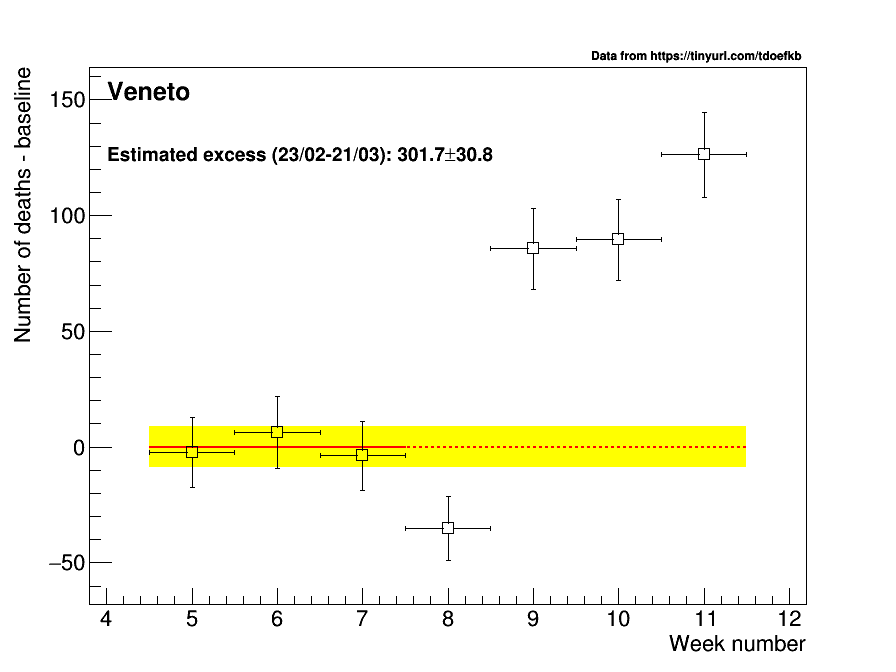

In [21]:
totalExcess={}
sumTotal=0
sumTotalRescaled=0

for p in regions:
    graphs['eccesso_deceduti_%s'%p].Draw("AP")
    graphs['eccesso_deceduti_%s'%p].GetXaxis().SetTitle("Week number")
    graphs['eccesso_deceduti_%s'%p].GetYaxis().SetTitle("Number of deaths - baseline")

    baseline_stdev=graphs['deceduti_%s'%p].GetFunction('fB').GetParError(0)
    box=R.TBox(firstWeek+0.5,-baseline_stdev,graphs['eccesso_deceduti_%s'%p].GetN()+firstWeek+0.5,baseline_stdev)
    box.SetFillColor(R.kYellow)
    box.Draw()
    line=R.TLine(firstWeek+0.5,0,graphs['eccesso_deceduti_%s'%p].GetN()+firstWeek+0.5,0)
    line.SetLineColor(R.kRed)
    line.SetLineStyle(2)
    line.SetLineWidth(2)
    line.Draw()
    line1=R.TLine(referenceWeek-0.5,0,7.5,0)
    line1.SetLineColor(R.kRed)
    line1.SetLineStyle(1)
    line1.SetLineWidth(2)
    line1.Draw()
    graphs['eccesso_deceduti_%s'%p].Draw("PSAME")

    totalExcess[p]=integralGraph(graphs['eccesso_deceduti_%s'%(p)],8-firstWeek)
    t.SetTextSize(0.03)
    t.DrawLatexNDC(0.12,0.76,'Estimated excess (23/02-21/03): %.1f#pm%.1f'%(totalExcess[p][0],totalExcess[p][1]))
    
    f0=R.TF1("f0","pol0",0,graphs['eccesso_deceduti_%s'%p].GetN()+6)
    graphs['eccesso_deceduti_%s'%p].Fit('f0','RB0Q','',firstWeek+0.5,graphs['eccesso_deceduti_%s'%p].GetN()+firstWeek+0.5)
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)
    t.SetTextSize(0.03)
    #if (f0.GetProb()>=1E-3):
    #    t.DrawLatexNDC(0.12,0.8,'p-value %.3f'%f0.GetProb())
    #else:
    #    t.DrawLatexNDC(0.12,0.8,'p-value < 0.001')

    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    c1.RedrawAxis()
    c1.Draw()
    
    sumTotal+=totalExcess[p][0]
    sumTotalRescaled+=totalExcess[p][0]/rescalingFactor[p]
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_{:s}".format(p)+ext)

In [22]:
print('Total Excess (Italy): %d'%sumTotal)
print('Total Excess Rescaled (Italy): %d'%sumTotalRescaled)

Total Excess (Italy): 9340
Total Excess Rescaled (Italy): 24752


ERROR in TPostScript::Open: Cannot open file:/Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/death_Trentino-Alto Adige/Südtirol.pd
ERROR in TPostScript::Open: Cannot open file:/Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/death_Trentino-Alto Adige/Südtirol.pn
ERROR in TPostScript::Open: Cannot open file:/Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/death_Trentino-Alto Adige/Südtirol.roo
ERROR in TPostScript::Open: Cannot open file:/Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/death_Valle d'Aosta/Vallée d'Aoste.pd
ERROR in TPostScript::Open: Cannot open file:/Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/death_Valle d'Aosta/Vallée d'Aoste.pn
ERROR in TPostScript::Open: Cannot open file:/Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/death_Valle d'Aosta/Vallée d'Aoste.roo


Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/death_Abruzzo.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/death_Abruzzo.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/death_Abruzzo.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/death_Basilicata.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/death_Basilicata.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/death_Basilicata.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/death_Calabria.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/death_Calabria.png has been created
Info in <TCanva

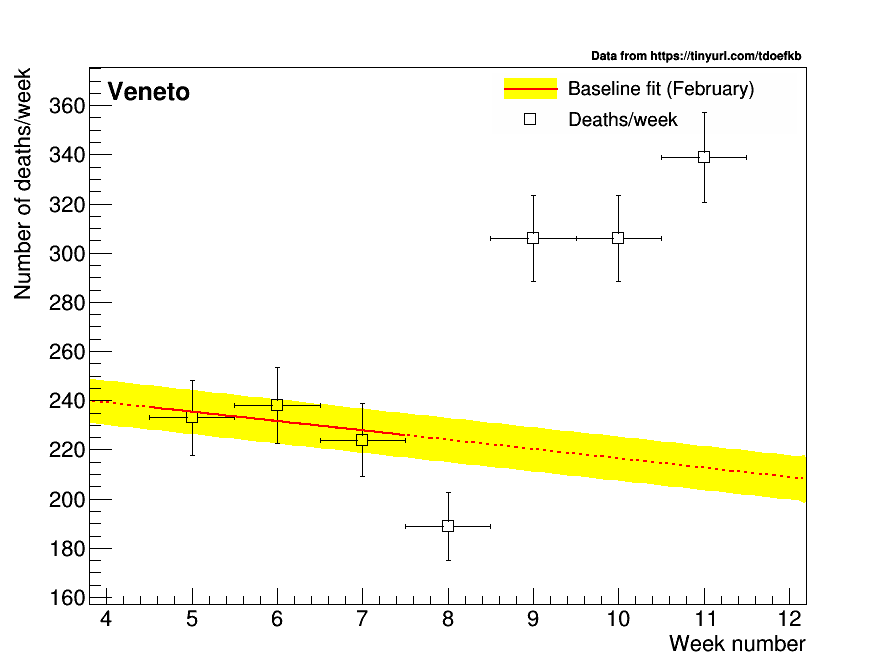

In [23]:
leg=R.TLegend(0.55,0.89,0.89,0.8)
leg.SetBorderSize(0)
leg.SetFillColorAlpha(0,0)
leg.SetTextSize(0.03)

for p in regions:
    leg.Clear()
    graphs['deceduti_%s'%p].Draw("AP")
    graphs['deceduti_%s'%p].GetXaxis().SetTitle("Week number")
    graphs['deceduti_%s'%p].GetYaxis().SetTitle("Number of deaths/week")
    
    f2=graphs['deceduti_%s'%p].GetFunction('fB').Clone()
    f2.SetRange(0,5.5+graphs['deceduti_%s'%p].GetN())
    f2.SetLineStyle(2)
    
    #make error band
    xA=graphs['deceduti_%s'%p].GetXaxis()
    xLow=xA.GetBinLowEdge(1)
    xHigh=xA.GetBinUpEdge(xA.GetNbins())
    xS = n.linspace(xLow, xHigh, 100)
    yS = [f2.Eval(x) for x in xS]
    xErr = n.zeros(100)
    yErr = [f2.GetParError(0) for x in xS]
    band=R.TGraphErrors(len(xS),xS,n.asarray(yS),xErr,n.asarray(yErr))
    band.SetFillColor(R.kYellow)
    
    band.Draw('4SAME')
    f2.Draw('LSAME')
    graphs['deceduti_%s'%p].Draw("PSAME")
    
    #auxiliary object for the legend
    aux=graphs['deceduti_%s'%p].Clone('aux')
    aux.SetFillColor(R.kYellow)
    aux.SetLineColor(R.kRed)
    aux.SetLineWidth(2)
    #aux.SetFillStyle(3000)
    leg.AddEntry(aux,'Baseline fit (February)','FL')
    leg.AddEntry(graphs['deceduti_%s'%p],'Deaths/week','P')
    
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)
    leg.Draw()
    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    c1.RedrawAxis()
    c1.Draw()
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA_ISTAT/death_{:s}".format(p)+ext)

In [24]:
yTot=n.zeros(len(weeks)-firstWeek)
yTotErr=n.zeros(len(weeks)-firstWeek)
yTotRescaled=n.zeros(len(weeks)-firstWeek)
yTotRescaledErr=n.zeros(len(weeks)-firstWeek)
baseline={'nazionale':0,'nazionale_rescaled':0}
for p in regions:
        baseline['nazionale']+=graphs['deceduti_%s'%p].GetFunction('fB').GetParError(0)*graphs['deceduti_%s'%p].GetFunction('fB').GetParError(0)
        baseline['nazionale_rescaled']+=graphs['deceduti_%s'%p].GetFunction('fB').GetParError(0)*graphs['deceduti_%s'%p].GetFunction('fB').GetParError(0)/(rescalingFactor[p]*rescalingFactor[p])
        for w in range(0,graphs['deceduti_%s'%p].GetN()):
            x,y=R.Double(0),R.Double(0)
            yerr=graphs['eccesso_deceduti_%s'%p].GetErrorY(w)
            graphs['eccesso_deceduti_%s'%p].GetPoint(w,x,y)
            #print(p,w,y)
            yTot[w]+=y
            yTotErr[w]=R.TMath.Sqrt(yTotErr[w]*yTotErr[w]+yerr*yerr)
            yTotRescaled[w]+=y/rescalingFactor[p]
            yTotRescaledErr[w]=yTotErr[w]/rescalingFactor[p]  

for p in ['nazionale','nazionale_rescaled']:
    baseline[p]=R.TMath.Sqrt(baseline[p])

print(yTot)

[-4.28882755e+01  7.33847258e+01  6.57727019e-01  2.11930728e+02
  1.28920373e+03  3.31047673e+03  4.74074973e+03]


In [25]:
graphs['eccesso_deceduti_nazionale']=R.TGraphErrors()
graphs['eccesso_deceduti_nazionale'].SetName('eccesso_deceduti_nazionale')

graphs['eccesso_deceduti_nazionale_rescaled']=R.TGraphErrors()
graphs['eccesso_deceduti_nazionale_rescaled'].SetName('eccesso_deceduti_nazionale_rescaled')

for w in range(0,graphs['eccesso_deceduti_Lombardia'].GetN()):
#print(w+firstWeek+1,yTot[w])
    graphs['eccesso_deceduti_nazionale'].SetPoint(w,w+firstWeek+1,yTot[w])
    graphs['eccesso_deceduti_nazionale'].SetPointError(w,0,yTotErr[w])
    graphs['eccesso_deceduti_nazionale_rescaled'].SetPoint(w,w+firstWeek+1,yTotRescaled[w])
    graphs['eccesso_deceduti_nazionale_rescaled'].SetPointError(w,0,yTotRescaledErr[w])

In [26]:
graphs['eccesso_deceduti_nazionale'].Print()

x[0]=5, y[0]=-42.8883, ex[0]=0, ey[0]=61.8466
x[1]=6, y[1]=73.3847, ex[1]=0, ey[1]=62.2816
x[2]=7, y[2]=0.657727, ex[2]=0, ey[2]=61.1882
x[3]=8, y[3]=211.931, ex[3]=0, ey[3]=62.3939
x[4]=9, y[4]=1289.2, ex[4]=0, ey[4]=70.0571
x[5]=10, y[5]=3310.48, ex[5]=0, ey[5]=82.8674
x[6]=11, y[6]=4740.75, ex[6]=0, ey[6]=90.7469


Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_nazionale.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_nazionale.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_nazionale.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_nazionale_rescaled.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_nazionale_rescaled.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_nazionale_rescaled.root has been created


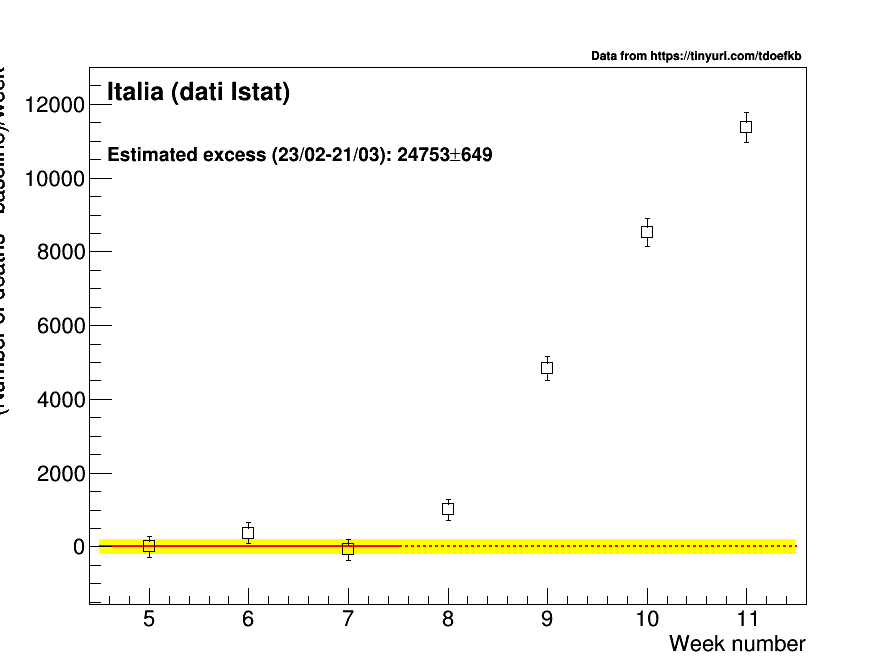

In [27]:
for p in ['nazionale','nazionale_rescaled']:
    graphs['eccesso_deceduti_%s'%p].Draw("AP")
    graphs['eccesso_deceduti_%s'%p].SetLineColor(R.kBlack)
    graphs['eccesso_deceduti_%s'%p].SetMarkerColor(R.kBlack)
    graphs['eccesso_deceduti_%s'%p].SetMarkerStyle(25)
    graphs['eccesso_deceduti_%s'%p].SetMarkerSize(1.4)
    graphs['eccesso_deceduti_%s'%p].GetXaxis().SetTitle("Week number")
    graphs['eccesso_deceduti_%s'%p].GetYaxis().SetTitle("(Number of deaths - baseline)/week")

    box=R.TBox(firstWeek+0.5,-baseline[p],graphs['eccesso_deceduti_%s'%p].GetN()+firstWeek+0.5,baseline[p])
    box.SetFillColor(R.kYellow)
    box.Draw()
    line=R.TLine(firstWeek+0.5,0,graphs['eccesso_deceduti_%s'%p].GetN()+firstWeek+0.5,0)
    line.SetLineColor(R.kRed)
    line.SetLineStyle(2)
    line.SetLineWidth(2)
    line.Draw()
    line1=R.TLine(referenceWeek-0.5,0,7.5,0)
    line1.SetLineColor(R.kRed)
    line1.SetLineStyle(1)
    line1.SetLineWidth(2)
    line1.Draw()
    graphs['eccesso_deceduti_%s'%p].Draw("PSAME")

    totalExcess[p]=integralGraph(graphs['eccesso_deceduti_%s'%(p)],8-firstWeek)
    t.SetTextSize(0.03)
    t.DrawLatexNDC(0.12,0.76,'Estimated excess (23/02-21/03): %.0f#pm%.0f'%(totalExcess[p][0],totalExcess[p][1]))

    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,'Italia (dati Istat)')
    
    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    c1.RedrawAxis()
    c1.Draw()

    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_{:s}".format(p)+ext)

In [28]:
for p in n.unique(dfByRegion['denominazione_regione']):
    df[p]=dfByRegion[dfByRegion['denominazione_regione']==p]

In [29]:
regionsToCompare=[
    'Lombardia',
    'Piemonte',
    'Veneto',
    'Emilia-Romagna',
    'Marche',
    'Lazio',
    'Liguria',
    'Toscana',
    'Sicilia',
]

limits={
    'deceduti':                   0,
    'terapia_intensiva':          1E-4*1E6,
    'totale_ospedalizzati':       1E-3*1e6,
    'nuovi_positivi': 0,
    'variazione_totale_positivi': 0,
    'dimessi_guariti': 0
}

keys={
    'deceduti'
}

dayDiff=2
for ip,p in enumerate(regionsToCompare):
    oldWeek=0
    for ik,k in enumerate(keys):
        graphs['%s_official_rescaled_%s'%(k,p)]=R.TGraphErrors()
        graphs['%s_official_rescaled_%s'%(k,p)].SetName('%s_official_rescaled_%s'%(k,p))
        graphs['%s_official_%s'%(k,p)]=R.TGraphErrors()
        graphs['%s_official_%s'%(k,p)].SetName('%s_official_%s'%(k,p))
        for i,ni in enumerate(df[p][k]):
            if((i+dayDiff)%7==0):
                weekD=float(ni)-oldWeek
                oldWeek=float(ni)
                weekN=int((i+dayDiff-1)/7)
                print(i,p,weekN+8,weekD,oldWeek)
                if ((weekN+8)>11):
                    continue
                graphs['%s_official_rescaled_%s'%(k,p)].SetPoint(weekN,weekN+8,weekD*rescalingFactor[p])
                graphs['%s_official_rescaled_%s'%(k,p)].SetPointError(weekN,0,0)
                graphs['%s_official_%s'%(k,p)].SetPoint(weekN,weekN+8,weekD)
                graphs['%s_official_%s'%(k,p)].SetPointError(weekN,0,0)

5 Lombardia 8 23.0 23.0
12 Lombardia 9 131.0 154.0
19 Lombardia 10 812.0 966.0
26 Lombardia 11 2129.0 3095.0
33 Lombardia 12 2849.0 5944.0
40 Lombardia 13 2712.0 8656.0
5 Piemonte 8 0.0 0.0
12 Piemonte 9 5.0 5.0
19 Piemonte 10 54.0 59.0
26 Piemonte 11 179.0 238.0
33 Piemonte 12 379.0 617.0
40 Piemonte 13 511.0 1128.0
5 Veneto 8 2.0 2.0
12 Veneto 9 11.0 13.0
19 Veneto 10 42.0 55.0
26 Veneto 11 91.0 146.0
33 Veneto 12 216.0 362.0
40 Veneto 13 245.0 607.0
5 Emilia-Romagna 8 4.0 4.0
12 Emilia-Romagna 9 44.0 48.0
19 Emilia-Romagna 10 193.0 241.0
26 Emilia-Romagna 11 474.0 715.0
33 Emilia-Romagna 12 629.0 1344.0
40 Emilia-Romagna 13 633.0 1977.0
5 Marche 8 0.0 0.0
12 Marche 9 6.0 6.0
19 Marche 10 30.0 36.0
26 Marche 11 118.0 154.0
33 Marche 12 210.0 364.0
40 Marche 13 210.0 574.0
5 Lazio 8 0.0 0.0
12 Lazio 9 1.0 1.0
19 Lazio 10 12.0 13.0
26 Lazio 11 37.0 50.0
33 Lazio 12 74.0 124.0
40 Lazio 13 88.0 212.0
5 Liguria 8 0.0 0.0
12 Liguria 9 4.0 4.0
19 Liguria 10 23.0 27.0
26 Liguria 11 125.0 152

Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcessComparison_Lombardia.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcessComparison_Lombardia.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcessComparison_Lombardia.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcessComparison_Piemonte.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcessComparison_Piemonte.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcessComparison_Piemonte.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcessComparison_Veneto.pdf has been created
Info in <TCanvas::Print>: p

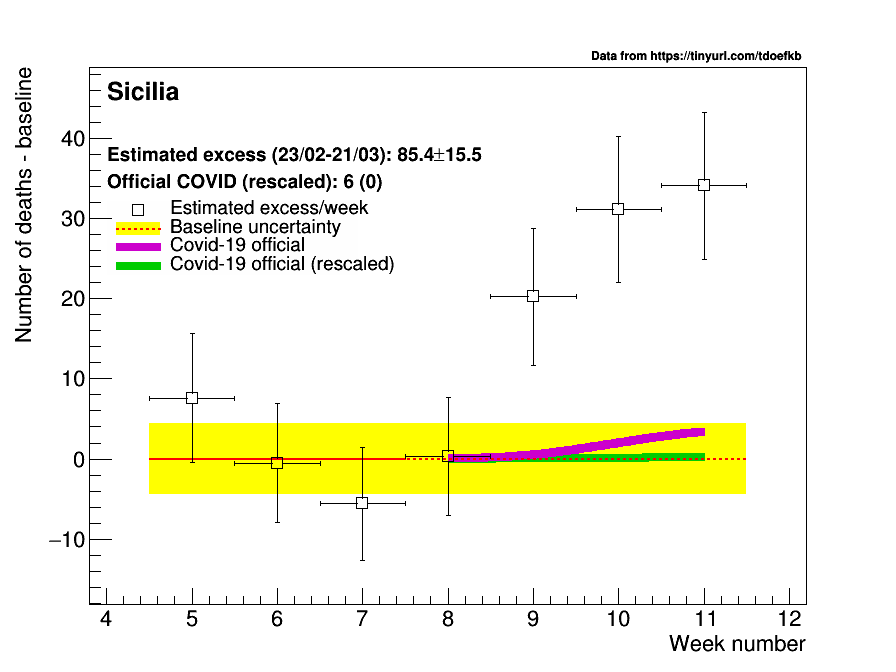

In [30]:
leg=R.TLegend(0.12,0.7,0.4,0.59)
leg.SetBorderSize(0)
leg.SetFillColorAlpha(0,0)
leg.SetTextSize(0.03)       

for p in regionsToCompare:
    leg.Clear()
    graphs['eccesso_deceduti_%s'%p].Draw("AP")
    graphs['eccesso_deceduti_%s'%p].GetXaxis().SetTitle("Week number")
    graphs['eccesso_deceduti_%s'%p].GetYaxis().SetTitle("Number of deaths - baseline")

    baseline_stdev=graphs['deceduti_%s'%p].GetFunction('fB').GetParError(0)
    box=R.TBox(firstWeek+0.5,-baseline_stdev,graphs['eccesso_deceduti_%s'%p].GetN()+firstWeek+0.5,baseline_stdev)
    box.SetFillColor(R.kYellow)
    box.Draw()
    line=R.TLine(firstWeek+0.5,0,graphs['eccesso_deceduti_%s'%p].GetN()+firstWeek+0.5,0)
    line.SetLineColor(R.kRed)
    line.SetLineStyle(2)
    line.SetLineWidth(2)
    line1=R.TLine(referenceWeek-0.5,0,7.5,0)
    line1.SetLineColor(R.kRed)
    line1.SetLineStyle(1)
    line1.SetLineWidth(2)

    graphs['deceduti_official_rescaled_%s'%p].SetLineColor(R.kGreen+1)
    graphs['deceduti_official_rescaled_%s'%p].SetLineWidth(8)
    #graphs['deceduti_official_rescaled_%s'%p].Draw('CSAME')
    line.Draw()
    line1.Draw()
    smoothedExt=smooth.SmoothKern(graphs['deceduti_official_rescaled_%s'%p],'normal',2)
    smoothedExt.SetLineColor(R.kGreen+1)
    smoothedExt.SetLineWidth(8)
    smoothedExt.Draw("LSAME")

    #graphs['deceduti_official_%s'%p].SetLineColor(R.kMagenta+1)
    #graphs['deceduti_official_%s'%p].SetLineWidth(8)
    #graphs['deceduti_official_rescaled_%s'%p].Draw('CSAME')
    smoothedExt1=smooth1.SmoothKern(graphs['deceduti_official_%s'%p],'normal',2)
    smoothedExt1.SetLineColor(R.kMagenta+1)
    smoothedExt1.SetLineWidth(8)
    smoothedExt1.Draw("LSAME")

    line.Draw()
    line1.Draw()

    graphs['eccesso_deceduti_%s'%p].Draw("PSAME")
           
    t.SetTextSize(0.03)
    t.DrawLatexNDC(0.12,0.76,'Estimated excess (23/02-21/03): %.1f#pm%.1f'%(totalExcess[p][0],totalExcess[p][1]))

    totalExcessRescaledCovid=integralGraph(graphs['deceduti_official_rescaled_%s'%p],0)
    totalExcessCovid=integralGraph(graphs['deceduti_official_%s'%p],0)
    
    t.SetTextSize(0.03)
    t.DrawLatexNDC(0.12,0.72,'Official COVID (rescaled): %.0f (%.0f)'%(totalExcessCovid[0],totalExcessRescaledCovid[0]))


    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)

    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    
    aux=R.TGraph()
    aux.SetFillColor(R.kYellow)
    aux.SetLineColor(R.kRed)
    aux.SetLineWidth(2)
    aux.SetLineStyle(2)
    
    leg.AddEntry(graphs['eccesso_deceduti_%s'%p],'Estimated excess/week','P')
    leg.AddEntry(aux,'Baseline uncertainty','FL')
    leg.AddEntry(smoothedExt1,'Covid-19 official ','L')
    leg.AddEntry(smoothedExt,'Covid-19 official (rescaled)','L')
    leg.Draw()
    
    c1.RedrawAxis()
    c1.Draw()
    
    sumTotal+=totalExcess[p][0]
    sumTotalRescaled+=totalExcess[p][0]/rescalingFactor[p]
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA_ISTAT/deathExcessComparison_{:s}".format(p)+ext)

In [31]:
baseline={ p:graphs['deceduti_%s'%p].GetFunction('fB').GetParameter(0) for p in regionsToCompare }
baselineRescaled={ p:graphs['deceduti_%s'%p].GetFunction('fB').GetParameter(0)*52/populationIstatByRegion[p] for p in regionsToCompare }

In [32]:
print(baseline)
print(baselineRescaled)

{'Lombardia': 1425.152462473424, 'Piemonte': 398.40532419225656, 'Veneto': 235.3717345979808, 'Emilia-Romagna': 411.62509387863486, 'Marche': 89.36842458831872, 'Lazio': 509.96516613448983, 'Liguria': 242.61518085628813, 'Toscana': 201.43377876384773, 'Sicilia': 56.39837196035519}
{'Lombardia': 0.010535758968848348, 'Piemonte': 0.012214501376976862, 'Veneto': 0.011442882678879622, 'Emilia-Romagna': 0.011596750386805141, 'Marche': 0.012859228689998737, 'Lazio': 0.00890292750366397, 'Liguria': 0.014134453773403747, 'Toscana': 0.012533421674129302, 'Sicilia': 0.010971173434458253}


In [ ]:
graphs['baselineRescaled']=R.TH1F('baselineRescaled','baselineRescaled')